This script calculates the daily likelihood of wetting rain and 95th percentile wind for every grid cell in models, and future change

It was run on a server, it would be very slow on a local machine.

In [1]:
import xarray as xr
import cftime
import pandas as pd
import numpy as np
import netCDF4
import os
import scipy.stats as stats
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import xarray as xr
import cftime
import pandas as pd
import cftime
import numpy as np
import netCDF4
import os
import cartopy.feature as cfeature
import scipy.stats as stats
from scipy.stats import rankdata
from scipy.stats import mannwhitneyu
import matplotlib.patches as mpatches
import datetime
from scipy.stats import gaussian_kde
import datetime
import matplotlib.ticker as ticker
import matplotlib.colors

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/cfgrib_.py:28: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  "Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. "


In [ ]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

In [2]:
# Create ticks for plotting
# Generate the date range from June 1st to November 30th
start_date = datetime.date(2023, 6, 1)
end_date = datetime.date(2023, 12, 30)
delta = datetime.timedelta(days=1)

dates = []
current_date = start_date
while current_date <= end_date:
    dates.append(current_date)
    current_date += delta
tick_positions = []
tick_labels = []

for i, date in enumerate(dates):
    if date.day == 1:
        tick_positions.append(i)
        tick_labels.append(date.strftime('%m/%d'))

## Historical Rain likelihood calculation

In [ ]:
for model in model_list:
    # rename to whatever you name your files
    
    directory = model_directory+'/'+model+'/pr/historical/'
    pr_dir = directory+'/'+model+'_pr_1981_2013.nc'
    pr = xr.open_dataset(pr_dir)
    
    # limit data to 1981-2010
    pr = pr.sel(day=slice('1981-01', '2010-12'))
    
    pr_vals = pr.prec
    
    testing_percentile = .95
    # calculate 2 week trailing precipitation for July-November
    months = [5,6,7,8,9,10,11,12]
    time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
    new_dataset = pr_vals.isel(day = time_index)
    window = 14
    shifted = new_dataset.rolling(day=window,center=False).construct("window")
    trailprtotal = shifted.sum(dim='window')
    # remove July
    months = [6,7,8,9,10,11,12]
    time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
    trailprtotal = trailprtotal.isel(day = time_index)
    
    lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
    lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])
    
    # Choose a bounding box
    # Create latitude and longitude masks
    latmask = (lat_wrf > 35) & (lat_wrf < 37)
    lonmask = (lon_wrf > -118) & (lon_wrf < -116)
        
    # Apply masks to trailprtotal using where method
    subset_array = trailprtotal
    #subset_coords = coords.where(latmask & lonmask,drop=True)
    
    
    # find average likelihoods
    
    # Define the start and end dates for the desired range
    start_date = '1981-06-01'
    end_date = '2010-11-30'
    
    # Extract the month and day parts from the start and end dates
    start_month_day = start_date[5:]
    end_month_day = end_date[5:]
    
    # Initialize lists to store proportions and wdprops
    proportions = []
    wdprops = []
    wdprop_nots = []
    cumulatives = []
    alldates = []
    # Loop over each date within the specified range
    current_date = start_date
    count=0
    while current_date[5:] < end_month_day:
        # Create a boolean mask for selecting the current date
        date_mask = subset_array.day.dt.strftime('%m-%d') == current_date[5:]
        # Select the subset of data for the current date
        subset_data = subset_array.where(date_mask,drop=True)
    
        # Count data > 12
        wetdays = sum(subset_data.values > 12)
        proportion = wetdays / len(subset_data)
        proportions.append(proportion)
        
        # Increment to the next day
        current_date = (pd.to_datetime(current_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    
    proportions = xr.DataArray(proportions,dims=['day','lat2d', 'lon2d'])
     
    
    # merge into a dataset
    
    data_dict = {'rain': proportions}
    dataset = xr.Dataset(data_dict)
    
    save_dir = '/~/'+model+'/entire_domain_rain.nc'
    dataset.to_netcdf(save_dir)

## Historical Wind Likelihood Calculation

In [ ]:
for model in model_list:
    

    directory = model_directory+'/'+model+'/sfcWind/historical/'
    sfcWind_dir = directory+'/'+model+'_sfcWind_1981_2013.nc'
    sfcWind = xr.open_dataset(sfcWind_dir)
    
    # limit data to 1981-2010
    sfcWind = sfcWind.sel(day=slice('1981-01', '2010-12'))
    
    sfcWind_vals = sfcWind.wspd10mean
    
    testing_percentile = .95
    
    UV = sfcWind_vals
    wind_prctiles = UV.quantile(testing_percentile,dim="day")
    months = [6,7,8,9,10,11]
    time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
    UV = UV.isel(day = time_index)
    # limit wind dataset to ASON
    # speed exceeds the wind percentile for each grid cell
    wd = xr.where(UV > wind_prctiles,1,0)
    
        
    #subset_coords = coords.where(latmask & lonmask,drop=True)
    subset_wind = wd
    
    # find average likelihoods
    
    # Define the start and end dates for the desired range
    start_date = '1981-06-01'
    end_date = '2010-11-30'
    
    # Extract the month and day parts from the start and end dates
    start_month_day = start_date[5:]
    end_month_day = end_date[5:]
    
    # Initialize lists to store proportions and wdprops
    wdprops = []
    cumulatives = []
    alldates = []
    # Loop over each date within the specified range
    current_date = start_date
    count=0
    while current_date[5:] < end_month_day:
        # Create a boolean mask for selecting the current date
        date_mask = subset_wind.day.dt.strftime('%m-%d') == current_date[5:]
        # Select the subset of data for the current date
        wdsubset = subset_wind.where(date_mask,drop=True)
        # Count data > 12
        wddays = sum(wdsubset == 1)
        # on this date, what is the likelihood of strong wind, based on climatology
        wdprop = wddays / len(wdsubset)
        wdprops.append(wdprop)
        # what is the chance that this day does NOT have strong wind
        # Increment to the next day
        current_date = (pd.to_datetime(current_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    
    wdprops = xr.DataArray(wdprops,dims=['day','lat2d', 'lon2d'])
    # cumulative likelihood calculation
    
    zeros_mask = (wdprops == 0).all(dim='day')
    # Remove the lat-lon points where the entire 'day' dimension is 0
    wdprops = wdprops.where(~zeros_mask, drop=True)
    
    # merge into a dataset
    
    data_dict = {'wind': wdprops}
    dataset = xr.Dataset(data_dict)
    
    save_dir = '/~/'+model+'/entire_domain_wind_all_year.nc'
    dataset.to_netcdf(save_dir)

## Historical Rain Transect Creation

In [3]:
# load in data
coords = xr.open_dataset('~wrfinput_d02_coord.nc')
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:

lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]



all_models = []
for x,model in enumerate(model_list):
    model_means = []
    file_dir = '/~/'+model+'/entire_domain_rain.nc'
    dataset = xr.open_dataset(file_dir)
    for lat_range, lon_range in lat_lon_ranges:
        latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
        lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
        model_subset = dataset.where(latmask & lonmask, drop=True)
        model_mean = model_subset.mean(dim=['lat2d', 'lon2d'])
        model_means.append(model_mean)
    model_means = xr.concat(model_means,dim='transect')
    # replace the index values with latitude values
    # Define the latitude ranges from lat_lon_ranges
    latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

    # Create a new DataArray with updated transect values
    new_transect = xr.DataArray(latitudes, dims='transect')

    # Update the heatmap_data with the new transect values
    model_means['transect'] = new_transect
    all_models.append(model_means)
model_array = xr.concat(all_models,dim='model')
model_array_mean = model_array.mean(dim='model')
model_array_new = xr.concat([model_array,model_array_mean],dim='model')
model_list.append('Ensemble Mean')

#data_dict= {'model_list': model_list, 'model_array_hist': model_array_new}
#dataset_hist = xr.Dataset(data_dict)
save_dir_hist = '/~/historical_rain_heatmap_data.nc'
model_array_new.to_netcdf(save_dir_hist)

## Future Wind Transect Creation

In [ ]:
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]



all_models = []
for x,model in enumerate(model_list):
    model_means = []
    file_dir = '~'/'+model+'/entire_domain_wind_all_year.nc'
    dataset = xr.open_dataset(file_dir)
    for lat_range, lon_range in lat_lon_ranges:
        latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
        lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
        model_subset = dataset.where(latmask & lonmask, drop=True)
        model_mean = model_subset.mean(dim=['lat2d', 'lon2d'])
        model_means.append(model_mean)
    model_means = xr.concat(model_means,dim='transect')
    # replace the index values with latitude values
    # Define the latitude ranges from lat_lon_ranges
    latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

    # Create a new DataArray with updated transect values
    new_transect = xr.DataArray(latitudes, dims='transect')

    # Update the heatmap_data with the new transect values
    model_means['transect'] = new_transect
    all_models.append(model_means)
model_array = xr.concat(all_models,dim='model')
model_array_mean = model_array.mean(dim='model')
model_array_wind = xr.concat([model_array,model_array_mean],dim='model')
model_list.append('Ensemble Mean')

save_dir_hist = '/~/historical_wind_heatmap_data.nc'
model_array_wind.to_netcdf(save_dir_hist)

## Plot Historical Rain and Wind in Models

In [3]:
# if loading from saved data
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')
# Historical rain data
model_array_hist = xr.open_dataset('/~/historical_rain_heatmap_data.nc')
# Historical wind data
model_array_wind_new = xr.open_dataset('/~/historical_wind_heatmap_data.nc')
model_list.append('Ensemble Mean')

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/xarray/backends/plugins.py:68: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
# Build some custom colormaps
rain_map = matplotlib.colors.ListedColormap(["sienna","sandybrown","peachpuff","linen","lightgreen","limegreen","forestgreen","darkgreen"])
light_rain_map2 = matplotlib.colors.ListedColormap(["goldenrod","burlywood","peachpuff","linen","seashell","honeydew","palegreen","lightgreen","limegreen","forestgreen"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:104: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


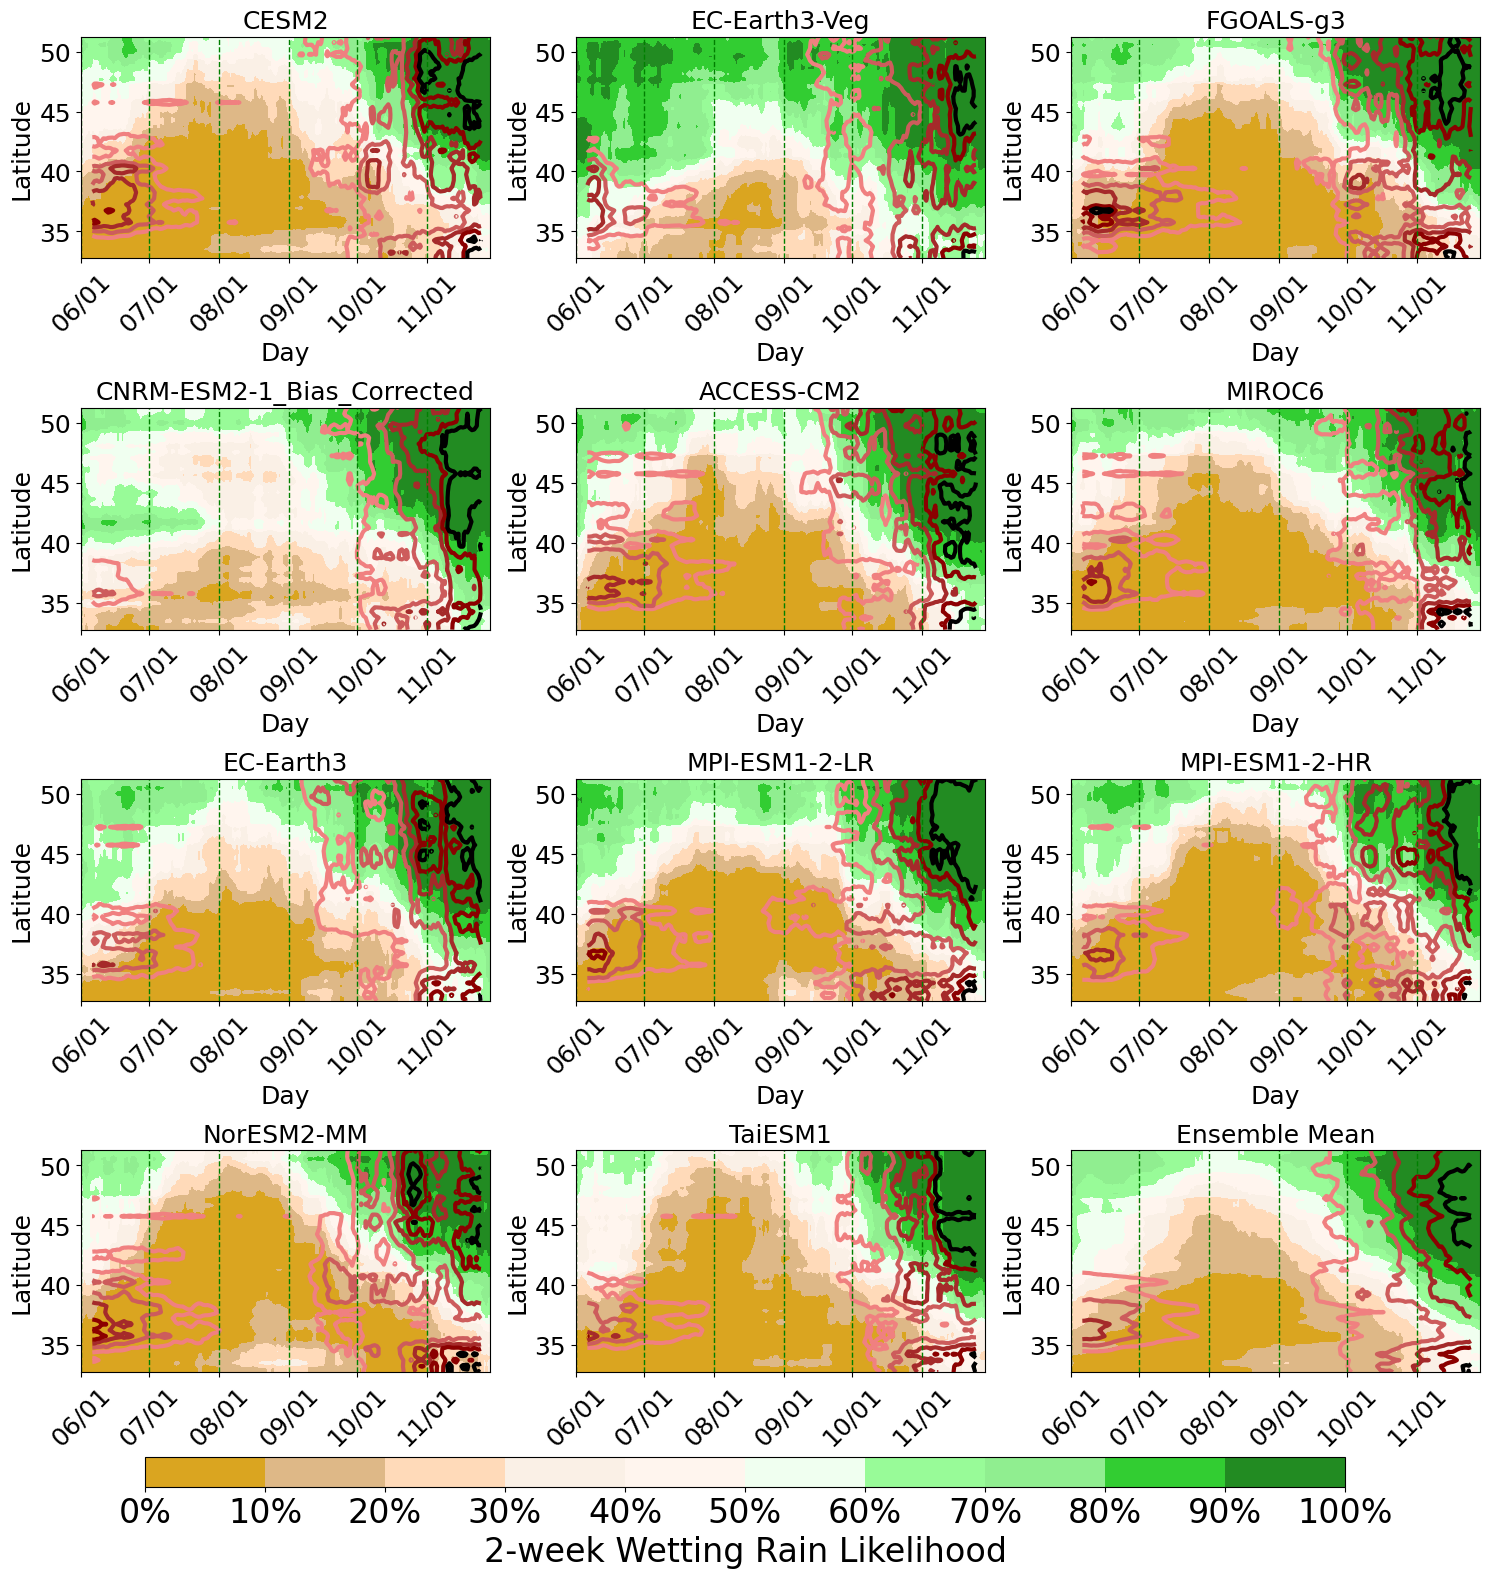

In [5]:
# Assuming you have your xarray dataset with dimensions (model: 10, day: 182, lat2d: N)
# Replace the following line with your actual dataset loading code
# model_array = xr.open_dataset('your_dataset.nc')

# Define the number of rows and columns for subplots
num_rows = 4
num_cols = 3

# Define the size of each subplot
subplot_width = 6  # Adjust as needed
subplot_height = 4  # Adjust as needed

# Create the figure with specified size
fig, axs = plt.subplots(num_rows, num_cols, figsize=([15,15]))

# Loop through the models (assuming there are 10 models)
for model_index in range(12):
    # Select the data for the current model
    model_selection = model_array_wind_new.sel(model=model_index)
    window_size = 10
    smooth_wind_model = []  # Create a list to store the averaged rain DataArrays
    smooth_wind_model = model_selection.rolling(day=window_size, center=True).mean()
    
    # Extract the numpy arrays from the xarray dataset
    day = smooth_wind_model['day'].values
    lat2d = smooth_wind_model['transect'].values
    wind = smooth_wind_model['wind'].values

    # Calculate the subplot position
    row = model_index // num_cols
    col = model_index % num_cols

    # Create the heatmap for the current model
    #im = axs[row, col].imshow(wind, extent=[day.min(), day.max(), lat2d.min(), lat2d.max()], aspect='auto',vmin=0,vmax=.25,cmap = 'Reds')
  #im = axs[row, col].imshow(wind, extent=[day.min(), day.max(), lat2d.min(), lat2d.max()], aspect='auto',vmin=0,vmax=.25,cmap = 'Reds')
    if model_index==11:
        contour_level = [.02]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='lightcoral', linewidths=3)
        
        contour_level = [.04]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='indianred', linewidths=3)
        
        contour_level = [.06]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='brown', linewidths=3)
        
        contour_level = [.08]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='darkred', linewidths=3)
        
        contour_level = [.1]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='black', linewidths=3)
        #axs[row, col].clabel(im, inline=True, fontsize=12, fmt='%.2f')
    else:
        
        contour_level = [.02]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='lightcoral', linewidths=3)
        
        contour_level = [.04]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='indianred', linewidths=3)
        
        contour_level = [.06]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='brown', linewidths=3)
        
        contour_level = [.08]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='darkred', linewidths=3)
        
        contour_level = [.1]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='black', linewidths=3)
    
    axs[row, col].set_title(f'Model {model_index + 1}')  # Set subplot title
    axs[row, col].set_xlabel('Day',fontsize=18)
    axs[row, col].set_ylabel('Latitude',fontsize=18)
    for tick_position in tick_positions:
        axs[row, col].axvline(tick_position, color='green', linestyle='dashed', linewidth=1)
        
    axs[row, col].set_xticks(tick_positions)
    axs[row, col].set_xticklabels(tick_labels, rotation=45,fontsize=18)
    axs[row, col].tick_params(axis='y', labelsize=18)
    axs[row, col].set_title(model_list[model_index],fontsize=18)
    
    
    
    ## Rain
    model_selection = model_array_hist.sel(model=model_index)
    
    # Extract the numpy arrays from the xarray dataset
    day = model_selection['day'].values
    lat2d = model_selection['transect'].values
    rain = model_selection['rain'].values

    # Calculate the subplot position
    row = model_index // num_cols
    col = model_index % num_cols

    # Create the heatmap for the current model
    im = axs[row, col].imshow(rain, cmap=light_rain_map2, extent=[day.min(), day.max(), lat2d.min(), lat2d.max()], aspect='auto',vmin=0,vmax=1)
    

# Adjust layout and display the subplots
#cax = fig.add_axes([0.999, 0.1, 0.02, 0.8])  # [x, y, width, height] values for the colorbar position
cbar_ax = fig.add_axes([0.1, 0.005, 0.8, 0.02]) 
cbar = plt.colorbar(im, cax=cbar_ax, label='Wind Likelihood', orientation='horizontal')
new_ticks = np.linspace(0, 1, 11)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
plt.tight_layout()
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('2-week Wetting Rain Likelihood',fontsize=24)  # Modify the colorbar label

plt.show()


## Future Rain Likelihood Calculation

In [ ]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')

In [ ]:
for model in model_list:
    
    directory = model_directory+'/'+model+'/pr/ssp370/'
    pr_dir = directory+'/'+model+'_pr_2065_2099.nc'
    
    pr = xr.open_dataset(pr_dir)
    pr = pr.sel(day=slice('2070-01', '2099-12'))
    
    pr_vals = pr.prec
    
    testing_percentile = .95
    # calculate 2 week trailing precipitation for July-November
    months = [5,6,7,8,9,10,11,12]
    time_index = [i for i, month in enumerate(pr_vals.day.dt.month) if month in months]
    new_dataset = pr_vals.isel(day = time_index)
    window = 14
    shifted = new_dataset.rolling(day=window,center=False).construct("window")
    trailprtotal = shifted.sum(dim='window')
    # remove July
    months = [6,7,8,9,10,11,12]
    time_index = [i for i, month in enumerate(trailprtotal.day.dt.month) if month in months]
    trailprtotal = trailprtotal.isel(day = time_index)
    
    
    
    lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
    lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])
    
    
    # Choose a bounding box
    # Create latitude and longitude masks
    latmask = (lat_wrf > 35) & (lat_wrf < 37)
    lonmask = (lon_wrf > -118) & (lon_wrf < -116)
    
    # Apply masks to trailprtotal using where method
    subset_array = trailprtotal
    #subset_coords = coords.where(latmask & lonmask,drop=True)
       
    
    start_date = '2070-06-01'
    end_date = '2099-11-30'
    # Extract the month and day parts from the start and end dates
    start_month_day = start_date[5:]
    end_month_day = end_date[5:]
    
    # Initialize lists to store proportions and wdprops
    proportions = []
    wdprops = []
    wdprop_nots = []
    cumulatives = []
    alldates = []
    # Loop over each date within the specified range
    current_date = start_date
    count=0
    while current_date[5:] < end_month_day:
        # Create a boolean mask for selecting the current date
        date_mask = subset_array.day.dt.strftime('%m-%d') == current_date[5:]
        # Select the subset of data for the current date
        subset_data = subset_array.where(date_mask,drop=True)
        # Count data > 12
        wetdays = sum(subset_data.values > 12)
        proportion = wetdays / len(subset_data)
        proportions.append(proportion)
        
        # Increment to the next day
        current_date = (pd.to_datetime(current_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    proportions = xr.DataArray(proportions,dims=['day','lat2d', 'lon2d'])
    
        
    zeros_mask = (proportions == 0).all(dim='day')
    # Remove the lat-lon points where the entire 'day' dimension is 0
    proportions = proportions.where(~zeros_mask, drop=True)
    
       
    
    # merge into a dataset
    
    data_dict = {'rain': proportions}
    dataset = xr.Dataset(data_dict)
    save_dir = '/~/'+model+'/entire_domain_future_rain.nc'
    dataset.to_netcdf(save_dir)

## Future Wind Likelihood Calculation

In [ ]:
for model in model_list:



    directory = model_directory+'/'+model+'/sfcWind/ssp370/'
    sfcWind_dir = directory+'/'+model+'_sfcWind_2065_2099.nc'
    sfcWind = xr.open_dataset(sfcWind_dir)
      
    sfcWind = sfcWind.sel(day=slice('2070-01', '2099-12'))
    
    sfcWind_vals = sfcWind.wspd10mean
    
    testing_percentile = .95
    
    
    UV = sfcWind_vals
    wind_prctiles = UV.quantile(testing_percentile,dim="day")
    months = [6,7,8,9,10,11]
    time_index = [i for i, month in enumerate(UV.day.dt.month) if month in months]
    UV = UV.isel(day = time_index)
    # limit wind dataset to ASON
    # speed exceeds the wind percentile for each grid cell
    wd = xr.where(UV > wind_prctiles,1,0)
    
    lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
    lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])
    
    
    # Choose a bounding box
    # Create latitude and longitude masks
    latmask = (lat_wrf > 35) & (lat_wrf < 37)
    lonmask = (lon_wrf > -118) & (lon_wrf < -116)
    
    # Apply masks to trailprtotal using where method
    #subset_coords = coords.where(latmask & lonmask,drop=True)
    subset_wind = wd
    
    start_date = '2070-06-01'
    end_date = '2099-11-30'
    # Extract the month and day parts from the start and end dates
    start_month_day = start_date[5:]
    end_month_day = end_date[5:]
    
    # Initialize lists to store proportions and wdprops
    proportions = []
    wdprops = []
    wdprop_nots = []
    cumulatives = []
    alldates = []
    # Loop over each date within the specified range
    current_date = start_date
    count=0
    while current_date[5:] < end_month_day:
        # Create a boolean mask for selecting the current date
        date_mask = subset_wind.day.dt.strftime('%m-%d') == current_date[5:]
        # Select the subset of data for the current date
    
        wdsubset = subset_wind.where(date_mask,drop=True)
        # Count data > 12
        
        wddays = sum(wdsubset == 1)
        # on this date, what is the likelihood of strong wind, based on climatology
        wdprop = wddays / len(wdsubset)
        wdprops.append(wdprop)
        # what is the chance that this day does NOT have strong wind
        
        # Increment to the next day
        current_date = (pd.to_datetime(current_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
    
    
    wdprops = xr.DataArray(wdprops,dims=['day','lat2d', 'lon2d'])
    
    
    
    
    zeros_mask = (wdprops == 0).all(dim='day')
    # Remove the lat-lon points where the entire 'day' dimension is 0
    wdprops = wdprops.where(~zeros_mask, drop=True)
    
    
    # merge into a dataset
    
    data_dict = {'wind': wdprops}
    dataset = xr.Dataset(data_dict)
    save_dir = '/~/'+model+'/entire_domain_future_wind_all_year.nc'
    dataset.to_netcdf(save_dir)a

## Future Rain Transect Creation

In [ ]:
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]


all_models = []
for x,model in enumerate(model_list):
    model_means = []
    file_dir = model_directory+'/likelihood_curves/'+model+'/entire_domain_future_rain.nc'
    dataset = xr.open_dataset(file_dir)
    for lat_range, lon_range in lat_lon_ranges:
        latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
        lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
        model_subset = dataset.where(latmask & lonmask, drop=True)
        model_mean = model_subset.mean(dim=['lat2d', 'lon2d'])
        model_means.append(model_mean)
    model_means = xr.concat(model_means,dim='transect')
    latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

    # Create a new DataArray with updated transect values
    new_transect = xr.DataArray(latitudes, dims='transect')

    # Update the heatmap_data with the new transect values
    model_means['transect'] = new_transect
    all_models.append(model_means)
model_array_fut = xr.concat(all_models,dim='model')

model_list.append('Ensemble Mean')
model_array_mean_fut = model_array_fut.mean(dim='model')
model_array_new_fut = xr.concat([model_array_fut,model_array_mean_fut],dim='model')

save_dir_fut = '/~/future_rain_heatmap_data.nc'
model_array_new_fut.to_netcdf(save_dir_fut)

## Future Wind Transect Creation

In [ ]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]


all_models = []
for x,model in enumerate(model_list):
    model_means = []
    file_dir = model_directory+'/likelihood_curves/'+model+'/entire_domain_future_wind_all_year.nc'
    dataset = xr.open_dataset(file_dir)
    for lat_range, lon_range in lat_lon_ranges:
        latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
        lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
        model_subset = dataset.where(latmask & lonmask, drop=True)
        model_mean = model_subset.mean(dim=['lat2d', 'lon2d'])
        model_means.append(model_mean)
    model_means = xr.concat(model_means,dim='transect')
    latitudes = [np.mean(lat_range) for lat_range, _ in lat_lon_ranges]

    # Create a new DataArray with updated transect values
    new_transect = xr.DataArray(latitudes, dims='transect')

    # Update the heatmap_data with the new transect values
    model_means['transect'] = new_transect
    all_models.append(model_means)
model_array_fut = xr.concat(all_models,dim='model')

model_list.append('Ensemble Mean')
model_array_mean_fut = model_array_fut.mean(dim='model')
model_array_wind_fut = xr.concat([model_array_fut,model_array_mean_fut],dim='model')

save_dir_fut = '/~/future_wind_heatmap_data.nc'
model_array_wind_fut.to_netcdf(save_dir_fut)

## Test significance of change

In [ ]:
coords = xr.open_dataset('/~/wrfinput_d02_coord.nc')
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [ ]:
lat_wrf = xr.DataArray(coords['lat2d'], dims=["lat2d", "lon2d"])
lon_wrf = xr.DataArray(coords['lon2d'], dims=["lat2d", "lon2d"])

lat_lon_ranges = [((51, 51.5), (-127, -123.5)),
                  ((50.5, 51), (-126, -123)),
                  ((50, 50.5), (-124.5, -122)),
                  ((49.5, 50), (-123.25, -121.5)),
                  ((49, 49.5), (-123, -120.75)),
                  ((48.5, 49), (-123, -120.75)),
                  ((48, 48.5), (-123, -121)),
                  ((47.5, 48), (-124.25, -121)),
                  ((47, 47.5), (-124.25, -121)),
                  ((46.5, 47), (-124, -121.5)),
                  ((46, 46.5), (-124, -121.5)),
                  ((45.5, 46), (-124, -121.5)),
                  ((45, 45.5), (-124, -121.5)),
                  ((44.5, 45), (-124, -121.5)),
                  ((44, 44.5), (-124, -121.5)),
                  ((43.5, 44), (-124, -122)),
                  ((43, 43.5), (-124.5, -122)),
                  ((42.5, 43), (-124.5, -122)),
                  ((42, 42.5), (-124.5, -122)),
                  ((41.5, 42), (-124, -122)),
                  ((41, 41.5), (-124, -122)),
                  ((40.5, 41), (-124.25, -121)),
                  ((40, 40.5), (-124.25, -121)),
                  ((39.5, 40), (-124, -120)),
                  ((39, 39.5), (-124, -120)),
                  ((38.5, 39), (-123.75, -120)),
                  ((38, 38.5), (-123.5, -119.5)),
                  ((37.5, 38), (-123, -119)),
                  ((37, 37.5), (-123, -118.75)),
                  ((36.5, 37), (-122, -118.25)),
                  ((36, 36.5), (-122, -118.25)),
                  ((35.5, 36), (-121.5, -118.5)),
                  ((35, 35.5), (-121.5, -118.5)),
                  ((34.5, 35), (-120.5, -118.5)),
                  ((34, 34.5), (-119.5, -116.75)),
                  ((33.5, 34), (-118.5, -116.5)),
                  ((33, 33.5), (-117.5, -116.5)),
                  ((32.5, 33), (-117.5, -116.5))]


all_pvals = []
for model in model_list:
    print(model)
    model_means = []
    file_dir = model_directory+'/likelihood_curves/'+model+'/entire_domain_rain.nc'
    file_dir2 = model_directory+'/likelihood_curves/'+model+'/entire_domain_future_rain.nc'
    dataset = xr.open_dataset(file_dir)
    dataset_fut = xr.open_dataset(file_dir2)
    # Define the number of rows and columns

    # Create a new 2D data array with all elements initialized to a default value (e.g., 0)
    pvals = xr.DataArray(np.empty((len(lat_lon_ranges), len(dataset.day))), dims=("Lat", "Day"))
    #pvals = np.empty((len(lat_lon_ranges), len(dataset.day)))
    
    chunk_size = 7
    
    for x, (lat_range, lon_range) in enumerate(lat_lon_ranges):
        latmask = (lat_wrf > lat_range[0]) & (lat_wrf < lat_range[1])
        lonmask = (lon_wrf > lon_range[0]) & (lon_wrf < lon_range[1])
        hist_model_subset = dataset.where(latmask & lonmask, drop=True)
        fut_model_subset = dataset_fut.where(latmask & lonmask, drop=True)
    
        # Iterate over chunks of 5 days
        for y,test_day in enumerate(hist_model_subset.day):
            sig_testing_data1 = hist_model_subset.sel(day=test_day).rain.values.ravel()
            sig_testing_data2 = fut_model_subset.sel(day=test_day).rain.values.ravel()
             #plt.hist(sig_testing_data,bins=12,range=(0,1))
        
            data1 = sig_testing_data1[~np.isnan(sig_testing_data1)]
            data2 = sig_testing_data2[~np.isnan(sig_testing_data2)]
            if np.array_equal(data1, data2):
                p_value = 1
            else:
            # Perform the Mann-Whitney U test
                statistic, p_value = stats.mannwhitneyu(data1, data2)
            
            # this starts from the top, so the first value will be the highest lat range
            
    
            pvals[x,y] = p_value
            
    all_pvals.append(pvals)

all_pvals = xr.concat(all_pvals,dim='model')

# This is starting from the top and going down, so you need to flip the data right?
#sig_yes = pvals < 0.05

save_dir = '/~/heatmap_significance_data.nc'
all_pvals.to_netcdf(save_dir)

## Plotting Future Change in Rain and Wind

In [6]:

model_array_fut = xr.open_dataset('/~/future_rain_heatmap_data.nc')
model_diff = model_array_fut - model_array_hist
model_array_wind_future_new = xr.open_dataset('/~/future_wind_heatmap_data.nc')
# Significance data

all_pvals = xr.open_dataset('/~/heatmap_significance_data.nc')
sig_yes= all_pvals < 0.01 

sig_sum = sig_yes.sum(dim='model')
half_count = sig_sum>=6

In [7]:
model_directory = '/model_directory/'
model_list = [folder for folder in os.listdir(model_directory) if os.path.isdir(os.path.join(model_directory, folder)) and folder != ".DS_Store"]

In [8]:
# Build some custom colormaps
import matplotlib.colors

segment_map3 = matplotlib.colors.ListedColormap(["royalblue","cornflowerblue","lightskyblue","lightcyan","mistyrose","lightcoral","indianred","firebrick"])
rain_map = matplotlib.colors.ListedColormap(["sienna","sandybrown","peachpuff","linen","lightgreen","limegreen","forestgreen","darkgreen"])
light_rain_map3 = matplotlib.colors.ListedColormap(["goldenrod","burlywood","peachpuff","linen","palegreen","lightgreen","limegreen","forestgreen"])

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:133: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


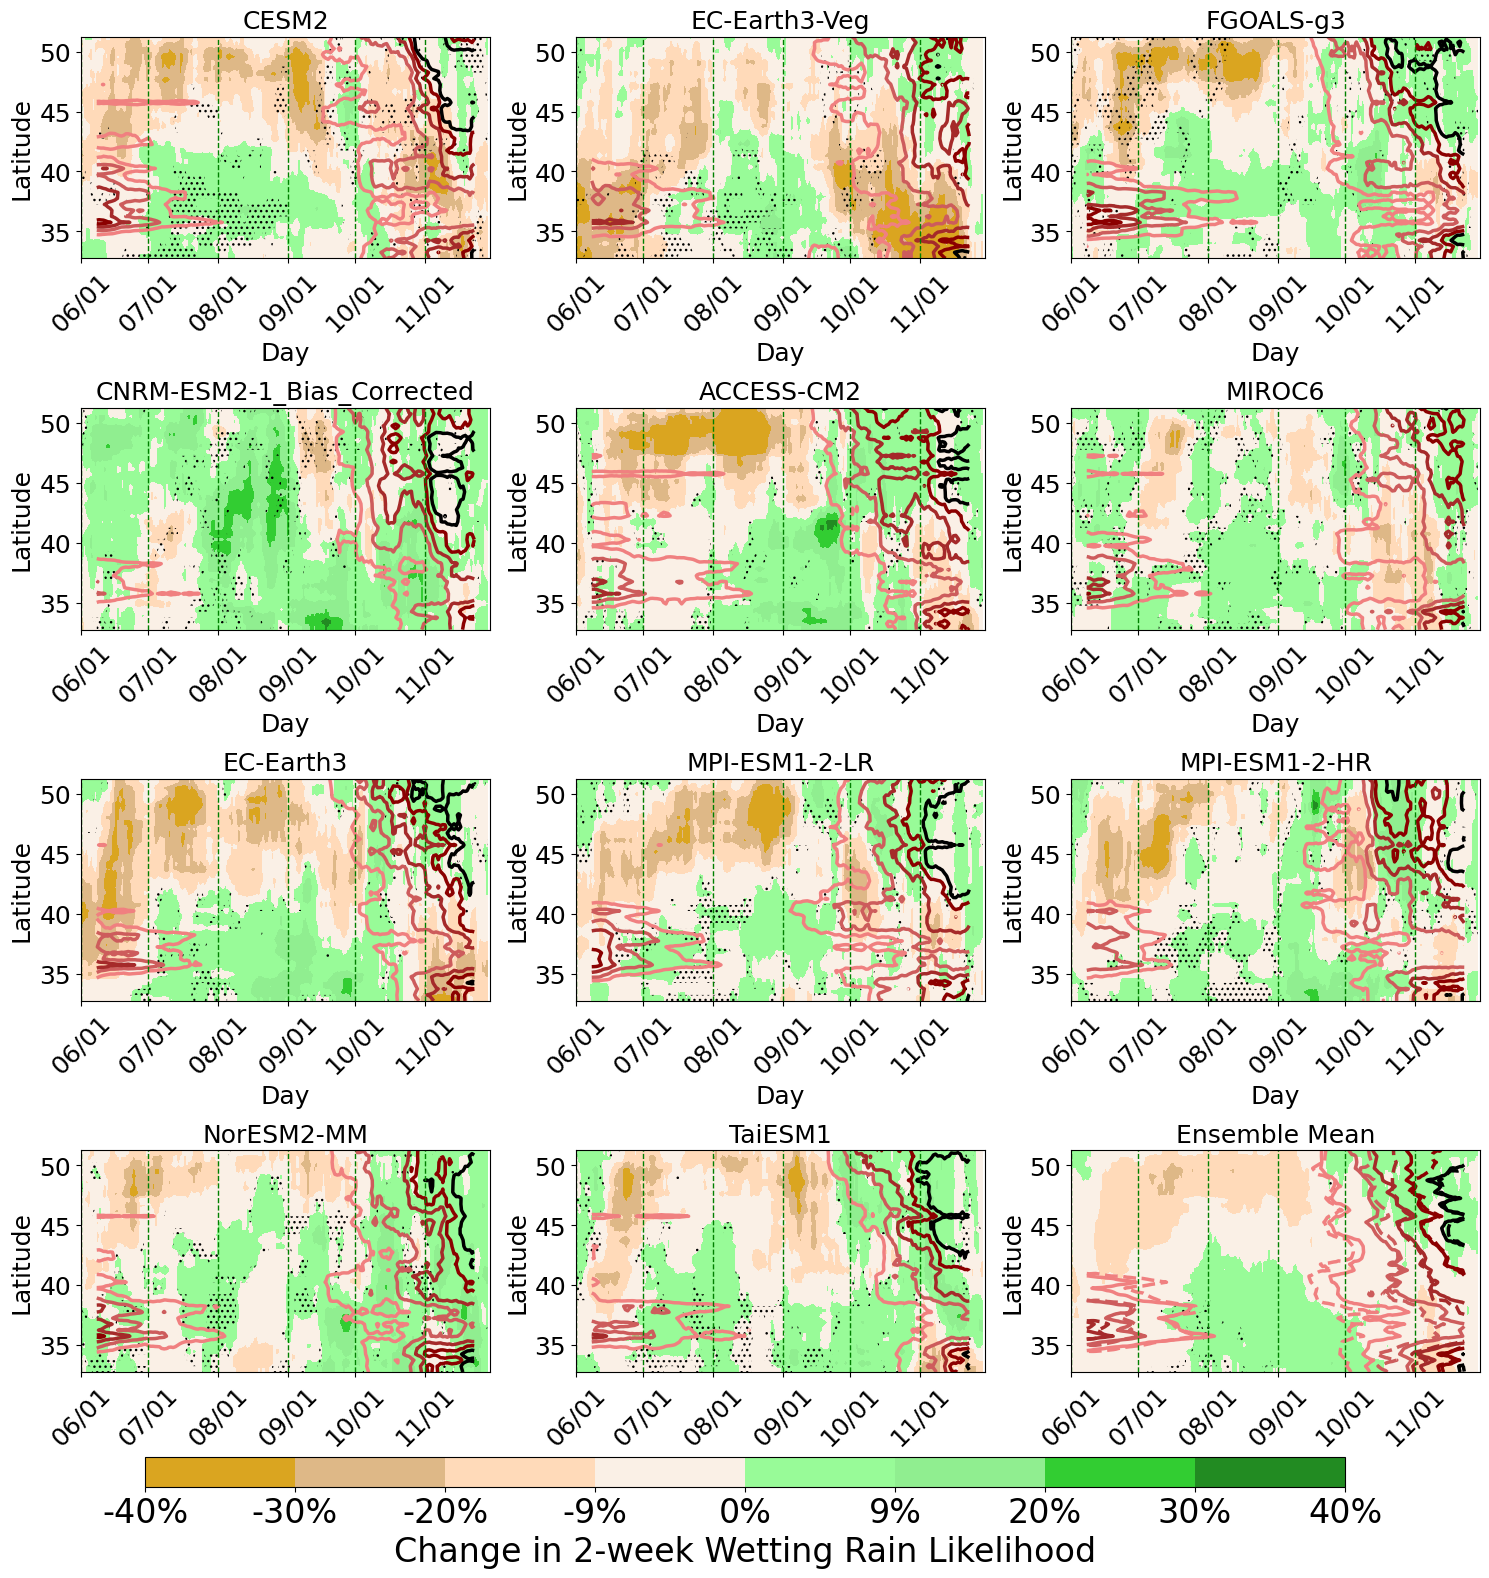

In [9]:
# Define the number of rows and columns for subplots
num_rows = 4
num_cols = 3

# Define the size of each subplot
subplot_width = 6  # Adjust as needed
subplot_height = 4  # Adjust as needed


fig, axs = plt.subplots(num_rows, num_cols, figsize=([15,15]))

for model_index in range(12):
    
    # Future Wind
    model_selection = model_array_wind_future_new.sel(model=model_index)
    window_size = 14
    smooth_wind_model = model_selection.rolling(day=window_size, center=True).mean()

    # Extract the numpy arrays from the xarray dataset
    day = smooth_wind_model['day'].values
    lat2d = smooth_wind_model['transect'].values
    wind = smooth_wind_model['wind'].values

    # Calculate the subplot position
    row = model_index // num_cols
    col = model_index % num_cols

    
    # Historical Wind code for the last subplot
    model_selection_hist = model_array_wind_new.sel(model=model_index)
    smooth_wind_model_hist = model_selection_hist.rolling(day=window_size, center=True).mean()

    day_hist = smooth_wind_model_hist['day'].values
    lat2d_hist = smooth_wind_model_hist['transect'].values
    wind_hist = smooth_wind_model_hist['wind'].values
    #levels = np.linspace(0, 0.1, 6)  # You can adjust the number of levels as needed
    #linewidths = np.linspace(1, 2, 6)
    #im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, colors='red', levels=levels, linewidths=linewidths)

    #im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, colors='green', levels=4, linewidths=1)
    #axs[row, col].clabel(im, inline=True, fontsize=12, fmt='%.2f')

    # Future Wind code for the last subplot
    #im = axs[row, col].contour(day, lat2d, wind, colors='black', levels=levels, linewidths=linewidths)
    #im = axs[row, col].contour(day, lat2d, wind, colors='black', levels=4, linewidths=1)
    #axs[row, col].clabel(im, inline=True, fontsize=12, fmt='%.2f')
    if model_index == 11:
        contour_level = [.02]
        im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='lightcoral', linewidths=2.5,linestyles='dashed')

        contour_level = [.04]
        im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='indianred', linewidths=2.5,linestyles='dashed')

        contour_level = [.06]
        im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='brown', linewidths=2.5,linestyles='dashed')

        contour_level = [.08]
        im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='darkred', linewidths=2.5,linestyles='dashed')

        contour_level = [.1]
        im = axs[row, col].contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='black', linewidths=2.5,linestyles='dashed')
        
        contour_level = [.02]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='lightcoral', linewidths=2.5)

        contour_level = [.04]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='indianred', linewidths=2.5)

        contour_level = [.06]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='brown', linewidths=2.5)

        contour_level = [.08]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='darkred', linewidths=2.5)

        contour_level = [.1]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='black', linewidths=2.5)
    else:
        
        contour_level = [.02]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='lightcoral', linewidths=2.5)

        contour_level = [.04]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='indianred', linewidths=2.5)

        contour_level = [.06]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='brown', linewidths=2.5)

        contour_level = [.08]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='darkred', linewidths=2.5)

        contour_level = [.1]
        im = axs[row, col].contour(day, lat2d, wind, levels=contour_level, colors='black', linewidths=2.5)
    

    axs[row, col].set_title(f'Model {model_index + 1}')  # Set subplot title
    axs[row, col].set_xlabel('Day', fontsize=18)
    axs[row, col].set_ylabel('Latitude', fontsize=18)
    for tick_position in tick_positions:
        axs[row, col].axvline(tick_position, color='green', linestyle='dashed', linewidth=1)
        
    axs[row, col].set_xticks(tick_positions)
    axs[row, col].set_xticklabels(tick_labels, rotation=45, fontsize=18)
    axs[row, col].set_title(model_list[model_index], fontsize=18)
    axs[row, col].tick_params(axis='y', labelsize=18)
  ## Rain
    
    if model_index < 11:
        sig_selection = sig_yes.sel(model=model_index)
    else:
        sig_selection = half_count

    model_selection = model_diff.sel(model=model_index)
    
    # Extract the numpy arrays from the xarray dataset
    day = model_selection['day'].values
    lat2d = model_selection['transect'].values
    rain = model_selection['rain'].values

    # Create the heatmap for the current model
    im = axs[row, col].imshow(rain, cmap=light_rain_map3, extent=[day.min(), day.max(), lat2d.min(), lat2d.max()], aspect='auto',vmin=-.4,vmax=.4)
    
    sig_selection_array = sig_selection.__xarray_dataarray_variable__
    sig_selection_array = np.where(sig_selection_array, np.nan,1)
    axs[row, col].contourf(day, lat2d, sig_selection_array, hatches=['...'], alpha=0, colors='none')
    axs[row, col].set_xlim(0, 182)
    


cax = fig.add_axes([0.1, 0.005, 0.8, 0.02])    # [x, y, width, height] values for the colorbar position
cbar = plt.colorbar(im, cax=cax, label='Wind Likelihood', orientation='horizontal')
new_ticks = np.linspace(-.4, .4, 9)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
plt.tight_layout()
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Change in 2-week Wetting Rain Likelihood',fontsize=24)

plt.show()


## Ensemble Mean

/Users/gt7/opt/anaconda3/envs/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:75: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


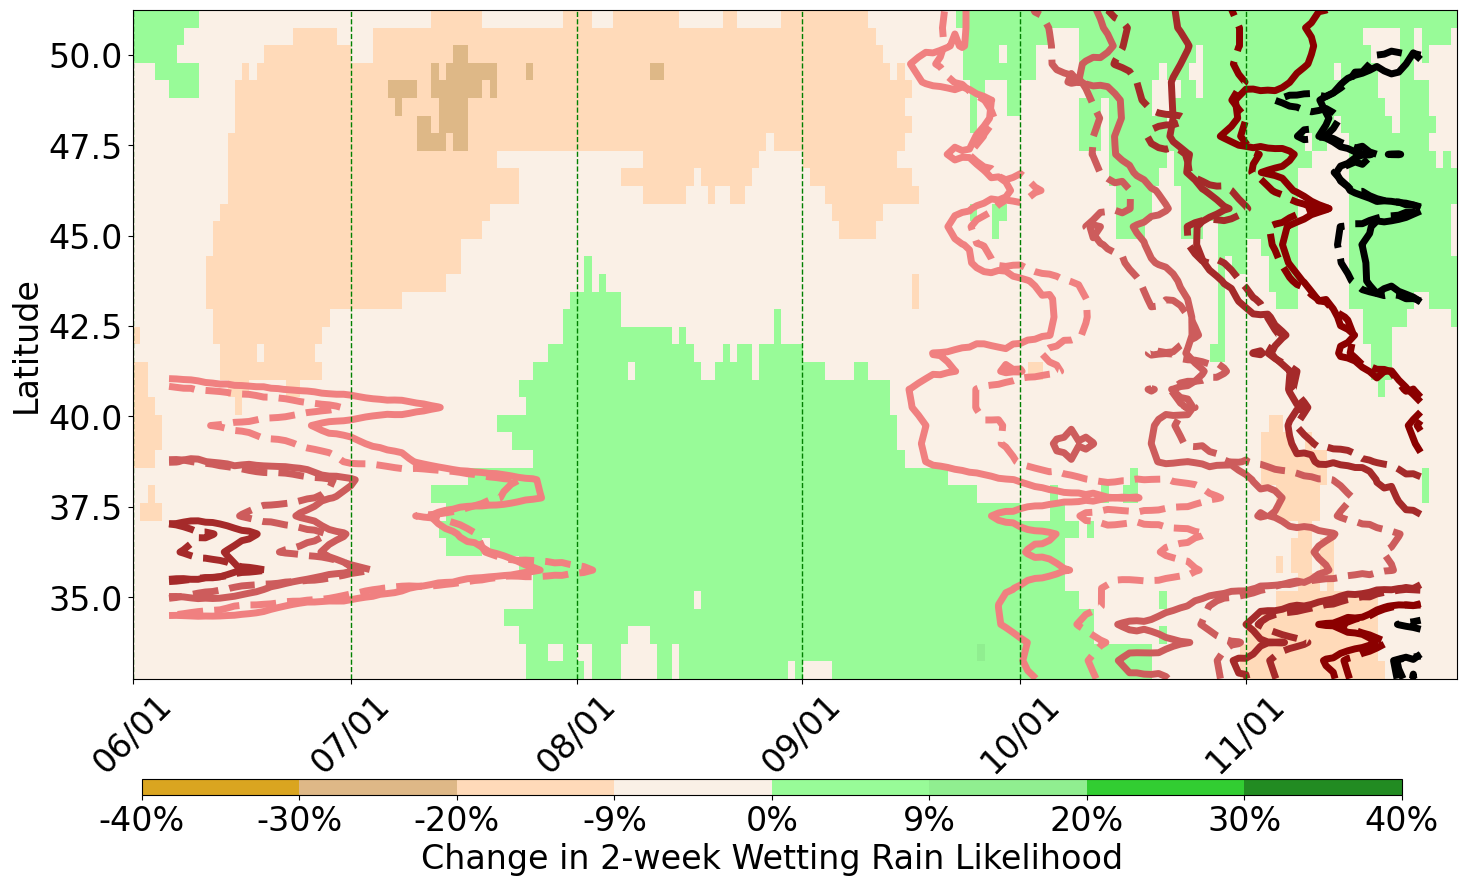

In [10]:
fig, ax = plt.subplots(figsize=[14,8])

# future wind
model_selection = model_array_wind_future_new.sel(model=11)
window_size = 10
smooth_wind_model = model_selection.rolling(day=window_size, center=True).mean()
day = smooth_wind_model['day'].values
lat2d = smooth_wind_model['transect'].values
wind = smooth_wind_model['wind'].values

# Historical Wind 
model_selection_hist = model_array_wind_new.sel(model=11)
smooth_wind_model_hist = model_selection_hist.rolling(day=window_size, center=True).mean()
day_hist = smooth_wind_model_hist['day'].values
lat2d_hist = smooth_wind_model_hist['transect'].values
wind_hist = smooth_wind_model_hist['wind'].values

# rain difference

model_selection = model_diff.sel(model=11)
day = model_selection['day'].values
lat2d = model_selection['transect'].values
rain = model_selection['rain'].values

# plot heatmap

im = ax.imshow(rain, cmap=light_rain_map3, extent=[0, 182, lat2d.min(), lat2d.max()], aspect='auto',vmin=-.4,vmax=.4)

# plot contours
contour_level = [.02]
contour = ax.contour(day, lat2d, wind, levels=contour_level, colors='lightcoral', linewidths=5,linestyles='dashed')

contour_level = [.04]
contour = ax.contour(day, lat2d, wind, levels=contour_level, colors='indianred', linewidths=5,linestyles='dashed')

contour_level = [.06]
contour = ax.contour(day, lat2d, wind, levels=contour_level, colors='brown', linewidths=5,linestyles='dashed')

contour_level = [.08]
contour = ax.contour(day, lat2d, wind, levels=contour_level, colors='darkred', linewidths=5,linestyles='dashed')

contour_level = [.1]
contour = ax.contour(day, lat2d, wind, levels=contour_level, colors='black', linewidths=5,linestyles='dashed')

# hist wind contours

contour_level = [.02]
contour = ax.contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='lightcoral', linewidths=5)

contour_level = [.04]
contour = ax.contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='indianred', linewidths=5)

contour_level = [.06]
contour = ax.contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='brown', linewidths=5)

contour_level = [.08]
contour = ax.contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='darkred', linewidths=5)

contour_level = [.1]
contour = ax.contour(day_hist, lat2d_hist, wind_hist, levels=contour_level, colors='black', linewidths=5)

# date ticks
for tick_position in tick_positions:
    ax.axvline(tick_position, color='green', linestyle='dashed', linewidth=1)

plt.xticks(tick_positions, tick_labels, rotation=45,fontsize=24)
ax.set_xlim(0, 182)

# colorbar stuff and ticks

cbar_ax = fig.add_axes([0.05, 0.00001, 0.9, 0.02]) 
cbar = plt.colorbar(im, cax=cbar_ax, label='Wind Likelihood', orientation='horizontal')
new_ticks = np.linspace(-.4, .4, 9)  # Adjust the number of ticks as needed
new_tick_labels = [f'{int(t*100)}%' for t in new_ticks]
plt.tight_layout()
cbar.set_ticks(new_ticks)
cbar.set_ticklabels(new_tick_labels)
cbar.ax.tick_params(labelsize=24)
cbar.set_label('Change in 2-week Wetting Rain Likelihood',fontsize=24) 
ax.tick_params(axis='y', labelsize=24)
ax.set_ylabel('Latitude', fontsize=24)


plt.show()